### HOMEWORK

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download using wget link mentioned below:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
# import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# #@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to median_house_value.

- Do train/validation/test split with 60%/20%/20% distribution.

- Use the train_test_split function and set the random_state parameter to 1.

In [4]:
df['median_house_value'] = np.log(1 + df.median_house_value)

In [5]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [8]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

We will use `DictVectorize` to turn train and validation into matrices.

In [9]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
train_dicts = df_train.fillna(0).to_dict(orient='records')

dv =  DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [10]:
#@ TRAINING THE REGRESSION MODEL:
rf = DecisionTreeRegressor(max_depth=1)
rf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
#@ INSPECTION:
print(export_text(rf, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/tatyjanaankudo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

Answer: **ocean_proximity**

### Question 2

Train a random forest model with these parameters:

- n_estimators=10

- random_state=1

- n_jobs=-1 (optional-to make training faster)

In [12]:
#@ TRAINING RANDOM FOREST MODEL:
rf2 = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
rf2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
y_pred = rf.predict(X_val)

In [14]:
#@ CALCULATING MEAN SQUARED ERROR:
def rmse(y, y_pred):
    se = error = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [15]:
rmse(y_val, y_pred)

0.46783724529735543

What's the RMSE of this model on validation?

Answer: **0.47**

### Question 3

Now, let's experiment with the n_estimators parameter.

- Try different values of this parameter from 10 to 200 with step 10.

- Set random_state to 1.

- Evaluate the model on the validation dataset.

In [16]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(
    n_estimators=n,
    random_state=1,
    n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)
    
    scores.append((n, score))

In [17]:
df_scores = pd.DataFrame(scores, columns=['n_est','RMSE'])

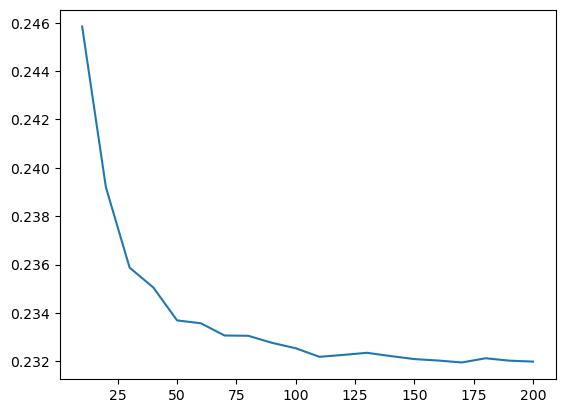

In [18]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_est, df_scores.RMSE)

- After which value of n_estimators does RMSE stop improving?

- Answer: **110**

### Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25].

- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).

- Fix the random seed: random_state=1.

In [19]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=d,
        random_state=1,
        n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)
        scores.append((d, n, score))

In [20]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_est', 'rmse'])

In [21]:
df_scores.head()

,max_depth,n_est,rmse
0,10,10,0.256078
1,10,20,0.253307
2,10,30,0.252039
3,10,40,0.251475
4,10,50,0.250527


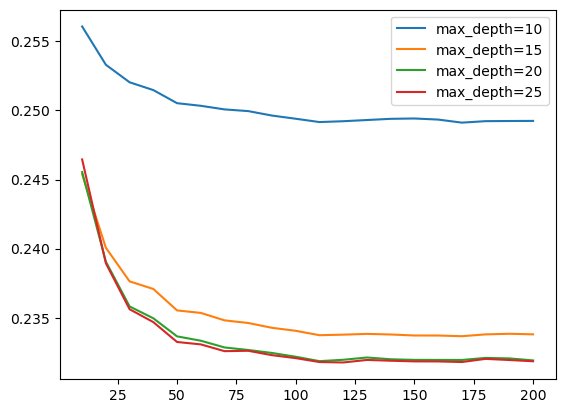

In [22]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_est, df_subset.rmse, label='max_depth=%d' %d)
    
plt.legend()

- What's the best max_depth:

- Answer: **10**

### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:

- n_estimators=10,

- max_depth=20,

- random_state=1,

- n_jobs=-1 (optional)

Get the feature importance information from this model

In [23]:
#@ TRAINING THE RANDOM FOREST MODEL:

rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

<AxesSubplot:>

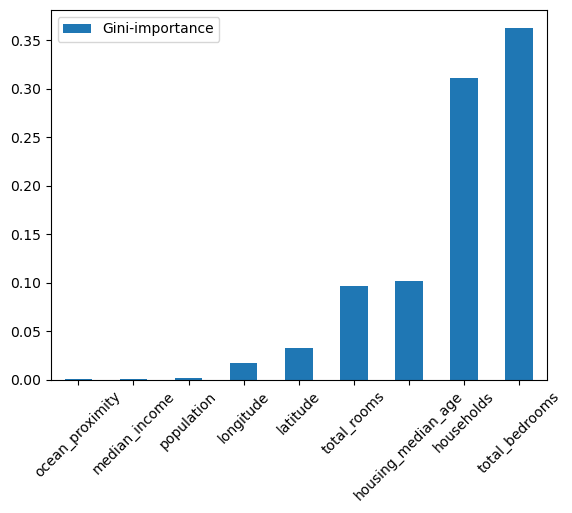

In [24]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_train.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

- What's the most important feature?

- Answer: **total_bedrooms**

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost.
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:

xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [27]:
import xgboost as xgb

In [28]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: **0.1**

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [30]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
scores = {}

In [32]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [33]:
scores['eta=0.3'] = parse_xgb_output(output)

In [34]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
scores['eta=0.1'] = parse_xgb_output(output)

(0.0, 100.0)

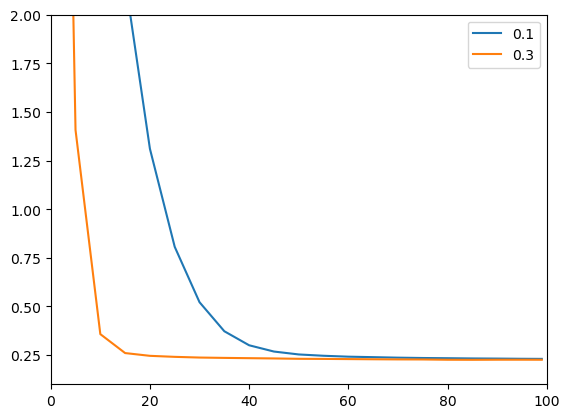

In [36]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0.1, 2])
plt.xlim([0, 100])